In [104]:
import pandas as pd
import time
import seaborn as sns
import datetime
from datetime import date, timedelta
import numpy as np

# We get BTC Exchange data from 2013 until 2 days before (for consistency matter)
yesterday = (date.today() - timedelta(2)).strftime('%Y%m%d')
# Bitcoin market data since 2013
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+yesterday)[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-09-13,6354.24,6535.41,6354.24,6517.31,4210910000,109703600477
1,2018-09-12,6317.01,6363.87,6265.09,6351.80,4064230000,109047547377
2,2018-09-11,6331.88,6398.92,6260.21,6321.20,3849910000,109293238395
3,2018-09-10,6301.57,6374.98,6292.76,6329.70,3714100000,108759350260
4,2018-09-09,6223.38,6446.26,6201.22,6300.86,3671890000,107397286192


In [105]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

In [106]:
# Getting Blockchain data
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import numpy as np

# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
avg_block_size = pd.read_csv(urllib.urlopen("https://blockchain.info/charts/avg-block-size?timespan=all&format=csv"))
# Format columns
avg_block_size = pd.DataFrame(avg_block_size.values, columns=['date', 'avg_block_size'])
avg_block_size['date'] = pd.to_datetime(avg_block_size['date'], format='%Y-%m-%d')
avg_block_size['date'] = pd.DataFrame(data=avg_block_size['date'], columns=['date'])

avg_block_size['date'] = pd.to_datetime(avg_block_size['date'])

# Add dates that do not appear at all, because their blocksize was same as the day before
avg_block_size = avg_block_size.set_index('date').resample('D').ffill()

# Reset index
avg_block_size.index.name='date'
data = avg_block_size.reset_index()
avg_block_size = data

# Drop values before 2013, to be consistent with BTC Exchange dataset
avg_block_size = avg_block_size.drop(avg_block_size[avg_block_size['date'] < '2013-04-28'].index)
avg_block_size = avg_block_size.reset_index(drop=True)

In [107]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]

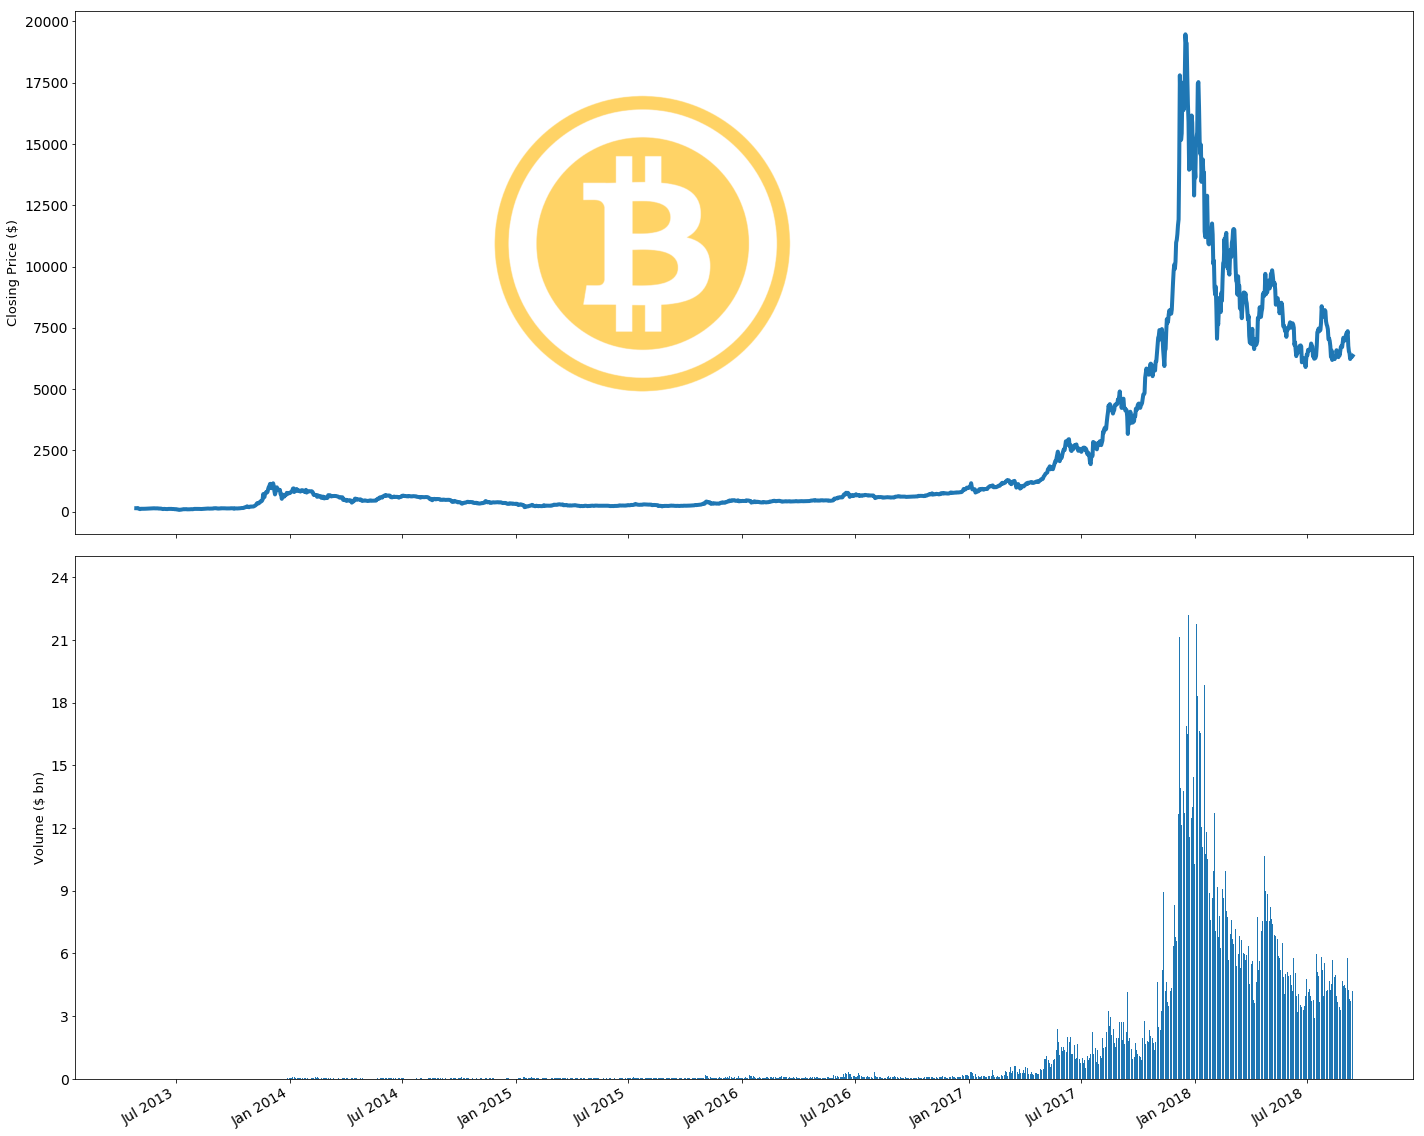

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 5]} )
fig.autofmt_xdate()

ax1.set_ylabel('Closing Price ($)',fontsize=13)
ax2.set_ylabel('Volume ($ bn)',fontsize=13)
ax2.set_yticks([int('%d000000000'%i) for i in range(0, 25, 3)])
ax2.set_yticklabels(range(0, 25, 3))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()

# print(bitcoin_market_info['bt_Volume'].values.max())
fig.figimage(bitcoin_im, 320, 650, zorder=3, alpha=.6)
plt.plot(subplots=True)
plt.show()

In [109]:
market_info = bitcoin_market_info
# '2013-04-28'
market_info = market_info[market_info['Date']>= '2014-01-01']
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.tail()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,bt_day_diff
1712,2014-01-05,858.55,952.40,854.52,933.53,72898496,10465699840,0.087333
1713,2014-01-04,823.27,859.51,801.67,859.51,38005000,10035600384,0.044020
1714,2014-01-03,802.85,834.15,789.12,818.72,37810100,9786680320,0.019767
1715,2014-01-02,773.44,820.31,767.21,802.39,38489500,9428179968,0.037430
1716,2014-01-01,754.97,775.35,754.97,771.40,22489400,9203030016,0.021762


### Training, Test

Typically the test data gets split into training, test, and validation data sets. The model is built using the training set, afterwards, the test set is used to evaluate the model. 
We generally train on one period of time and then test on another separate period. Rather arbitrary, I'll set the cut-off date to February 1st 2018. The model will be trained on data before that date (unfortunately we'll have to make use even of data on 2013-2015 when Bitcoin wasn't that popular), and after this the remaining is left for testing :)

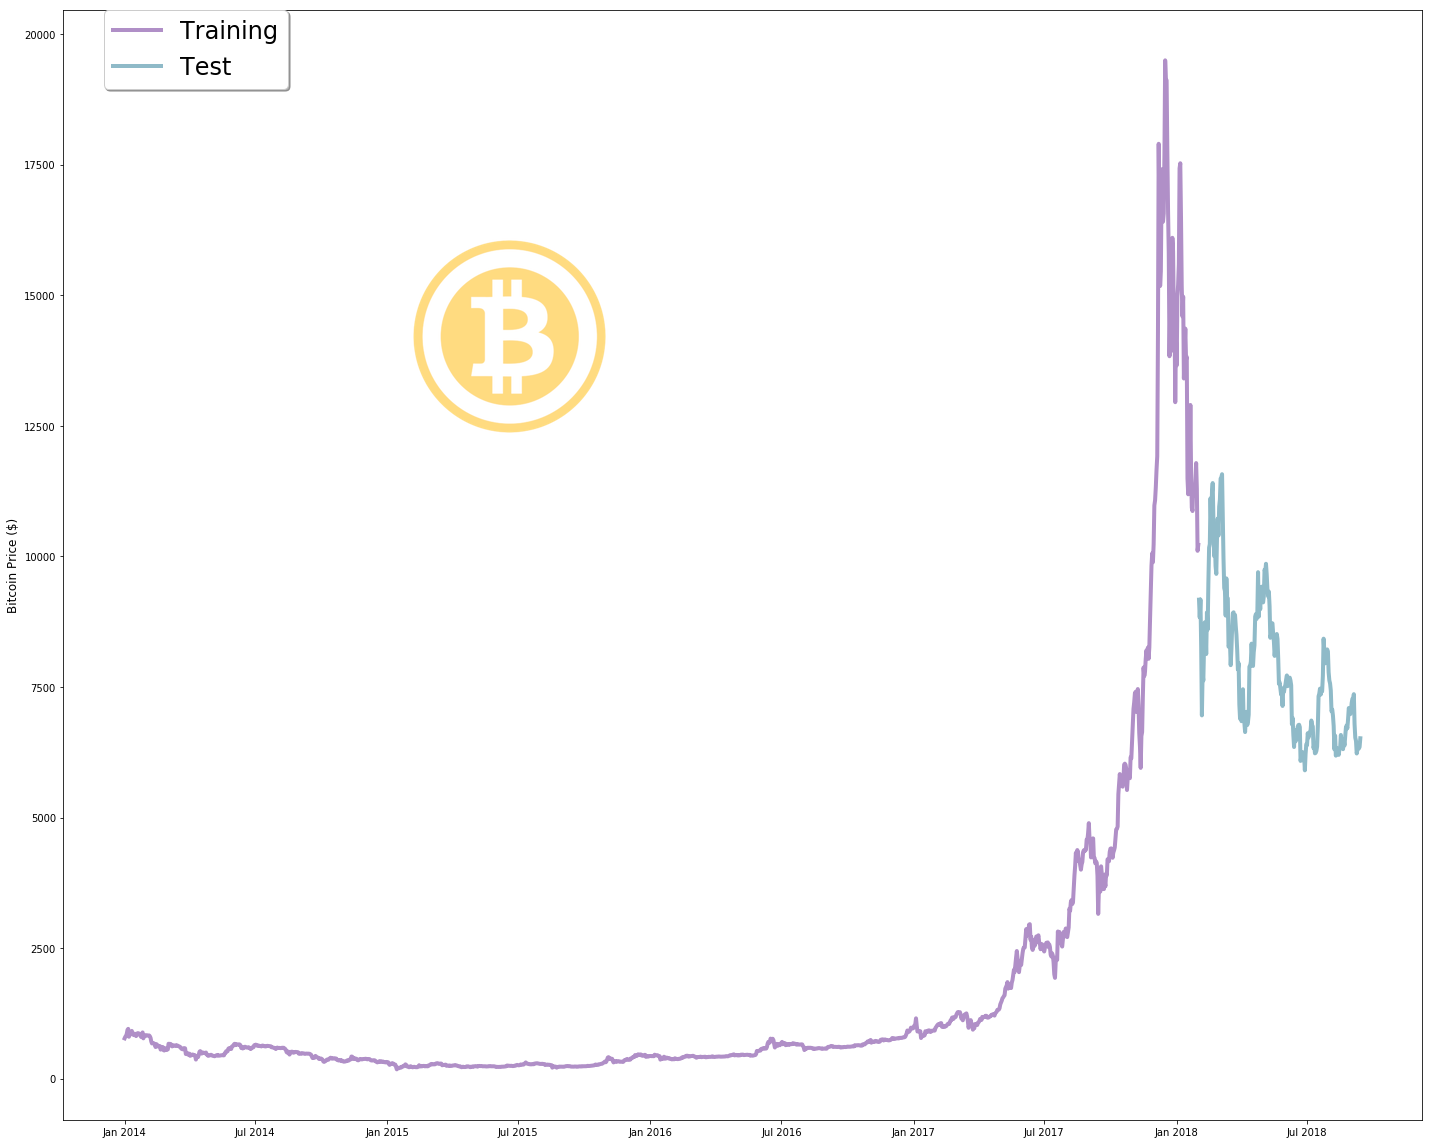

In [110]:
split_date = '2018-02-01'

from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig, (ax1) = plt.subplots()

ax1.set_xticks([datetime.date(i,j,1) for i in range(2014,2019) for j in [1,7]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y') for i in range(2014,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 24}, shadow=True)
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             300, 650, zorder=3,alpha=.5)
plt.plot(subplots=True)
plt.show()

Firstly, let's check whether the daily change in price follow a normal distribution.One way to see this is by ploting the histograms

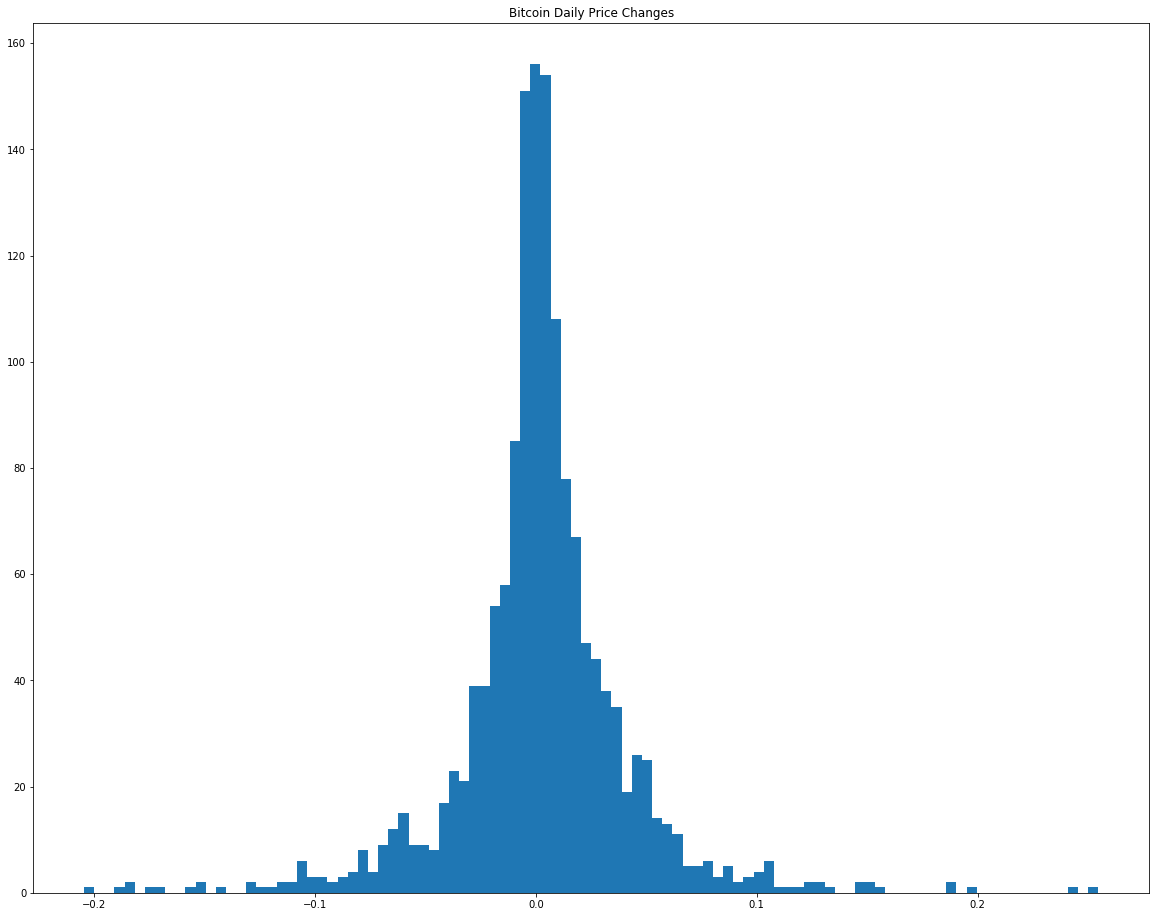

In [111]:
fig, ax1 = plt.subplots()
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
plt.show()

## Long Short Term Memory (LSTM)

For LSTM Theory read: [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [this](http://blog.echen.me/2017/05/30/exploring-lstms/) and [this](http://www.bioinf.jku.at/publications/older/2604.pdf). Nevertheless, various implementations of deep learning algorithms are provided out of the box by different packages (e.g. [TensorFlow](https://www.tensorflow.org/get_started/get_started), [Keras](https://keras.io/#keras-the-python-deep-learning-library), [PyTorch](http://pytorch.org/), etc.). Here I use Keras, since it's really really convinient and was build with tensorflow in mind ;)

In [112]:
for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)
    
market_info.tail()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,bt_day_diff,bt_close_off_high,bt_volatility
1712,2014-01-05,858.55,952.40,854.52,933.53,72898496,10465699840,0.087333,-0.614426,0.114006
1713,2014-01-04,823.27,859.51,801.67,859.51,38005000,10035600384,0.044020,-1.000000,0.070256
1714,2014-01-03,802.85,834.15,789.12,818.72,37810100,9786680320,0.019767,-0.314679,0.056088
1715,2014-01-02,773.44,820.31,767.21,802.39,38489500,9428179968,0.037430,-0.325047,0.068654
1716,2014-01-01,754.97,775.35,754.97,771.40,22489400,9203030016,0.021762,-0.612365,0.026994


In [113]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
1716,2014-01-01,771.40,22489400,-0.612365,0.026994
1715,2014-01-02,802.39,38489500,-0.325047,0.068654
1714,2014-01-03,818.72,37810100,-0.314679,0.056088
1713,2014-01-04,859.51,38005000,-1.000000,0.070256
1712,2014-01-05,933.53,72898496,-0.614426,0.114006


In [114]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
# print(training_set)
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [115]:
window_len = 40
norm_cols = [coin+metric for coin in ['bt_'] for metric in ['Close','Volume']]
print(norm_cols)

['bt_Close', 'bt_Volume']


In [120]:
# LSTM_training_inputs = []
# # print(training_set)
# for i in range(len(training_set)-window_len):
#     temp_set = training_set[i:(i+window_len)].copy()
#     for col in norm_cols:
#         # Before 2015 the bitcoin volume was 0 => we cant divide by zero, so we leave it as is
#         if(temp_set.loc[:, col].name=="bt_Volume"):
#             # print(type(temp_set.loc[:, col]))
#             if((temp_set.loc[:, col] != 0).any()):
#                 temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
# #         elif(temp_set.loc[:, col].name=="bt_Close"):
# #                 a = temp_set.loc[:, col][lambda x : x==0.000000]
# #                 print(a)
# #                 print(temp_set.loc[:, col].name)
#         else:
#             temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
#     LSTM_training_inputs.append(temp_set)
# LSTM_training_outputs = (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1
# # print(LSTM_training_outputs)


LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1
print(LSTM_training_inputs[0])

      bt_Close  bt_Volume  bt_close_off_high  bt_volatility
1716  0.000000   0.000000          -0.612365       0.026994
1715  0.040174   0.711451          -0.325047       0.068654
1714  0.061343   0.681241          -0.314679       0.056088
1713  0.114221   0.689907          -1.000000       0.070256
1712  0.210176   2.241460          -0.614426       0.114006
1711  0.235792   2.804712           0.145858       0.119021
1710  0.039668   2.615556           1.000000       0.172997
1709  0.092455   2.298247          -0.408254       0.118720
1708  0.097822   1.667861          -0.418798       0.071565
1707  0.125849   0.417414          -0.888454       0.057388
1706  0.184794   0.990013          -0.747992       0.068902
1705  0.119030   0.761874           0.688429       0.084113
1704  0.090485   1.026773          -0.272629       0.064218
1703  0.080205  -0.073795           0.493173       0.035616
1702  0.116023   0.249798          -0.432181       0.050353
1701  0.083264  -0.148519           1.00

In [121]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_Close'][window_len:].values/test_set['bt_Close'][:-window_len].values)-1
print(LSTM_test_outputs)

[ 0.00265088 -0.06352122 -0.09526524  0.00741089  0.13825631  0.06057261
  0.13243804  0.07838279  0.02200989  0.01236038  0.09220821 -0.02895289
 -0.01192444 -0.13536388 -0.22951684 -0.22273229 -0.35517921 -0.34698156
 -0.37876671 -0.39982374 -0.33736811 -0.25476162 -0.3346497  -0.30587777
 -0.31334657 -0.33333751 -0.34516297 -0.34883678 -0.375878   -0.37145331
 -0.31336327 -0.31414624 -0.30994271 -0.22734812 -0.19134881 -0.15890563
 -0.12574283 -0.06448116 -0.07650363 -0.03362694 -0.04267498  0.07993775
  0.16825245  0.06085017  0.17236967  0.09282584  0.08317218  0.05672426
  0.03485947  0.04474324  0.04012559  0.12410304  0.14183277  0.20083685
  0.23257382  0.17833095  0.28875337  0.35333473  0.29689555  0.23337322
  0.20061125  0.17003907  0.27181113  0.24941899  0.26106487  0.17120744
  0.1747628   0.21806364  0.24558141  0.20818074  0.0193339  -0.04282443
 -0.04994841 -0.10192806 -0.08720918 -0.06756061 -0.12585779 -0.09907033
 -0.16271057 -0.15754004 -0.14325654 -0.14415489 -0

In [122]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
1716,0.000000,0.000000,-0.612365,0.026994
1715,0.040174,0.711451,-0.325047,0.068654
1714,0.061343,0.681241,-0.314679,0.056088
1713,0.114221,0.689907,-1.000000,0.070256
1712,0.210176,2.241460,-0.614426,0.114006
1711,0.235792,2.804712,0.145858,0.119021
1710,0.039668,2.615556,1.000000,0.172997
1709,0.092455,2.298247,-0.408254,0.118720
1708,0.097822,1.667861,-0.418798,0.071565
1707,0.125849,0.417414,-0.888454,0.057388


In [123]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [124]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [98]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 15s - loss: 0.0563
Epoch 2/50
 - 19s - loss: 0.0386
Epoch 3/50
 - 12s - loss: 0.0354
Epoch 4/50
 - 14s - loss: 0.0327
Epoch 5/50
 - 11s - loss: 0.0326
Epoch 6/50
 - 7s - loss: 0.0319
Epoch 7/50
 - 7s - loss: 0.0304
Epoch 8/50
 - 13s - loss: 0.0306
Epoch 9/50
 - 7s - loss: 0.0302
Epoch 10/50
 - 6s - loss: 0.0306
Epoch 11/50
 - 12s - loss: 0.0303
Epoch 12/50
 - 9s - loss: 0.0305
Epoch 13/50
 - 6s - loss: 0.0297
Epoch 14/50
 - 8s - loss: 0.0293
Epoch 15/50
 - 8s - loss: 0.0299
Epoch 16/50
 - 8s - loss: 0.0303
Epoch 17/50
 - 16s - loss: 0.0295
Epoch 18/50
 - 14s - loss: 0.0294
Epoch 19/50
 - 6s - loss: 0.0300
Epoch 20/50
 - 6s - loss: 0.0294
Epoch 21/50
 - 8s - loss: 0.0293
Epoch 22/50
 - 8s - loss: 0.0294
Epoch 23/50
 - 10s - loss: 0.0289
Epoch 24/50
 - 8s - loss: 0.0294
Epoch 25/50
 - 8s - loss: 0.0289
Epoch 26/50
 - 7s - loss: 0.0291
Epoch 27/50
 - 8s - loss: 0.0290
Epoch 28/50
 - 8s - loss: 0.0288
Epoch 29/50
 - 8s - loss: 0.0289
Epoch 30/50
 - 8s - loss: 0.0295
Epoch 31/

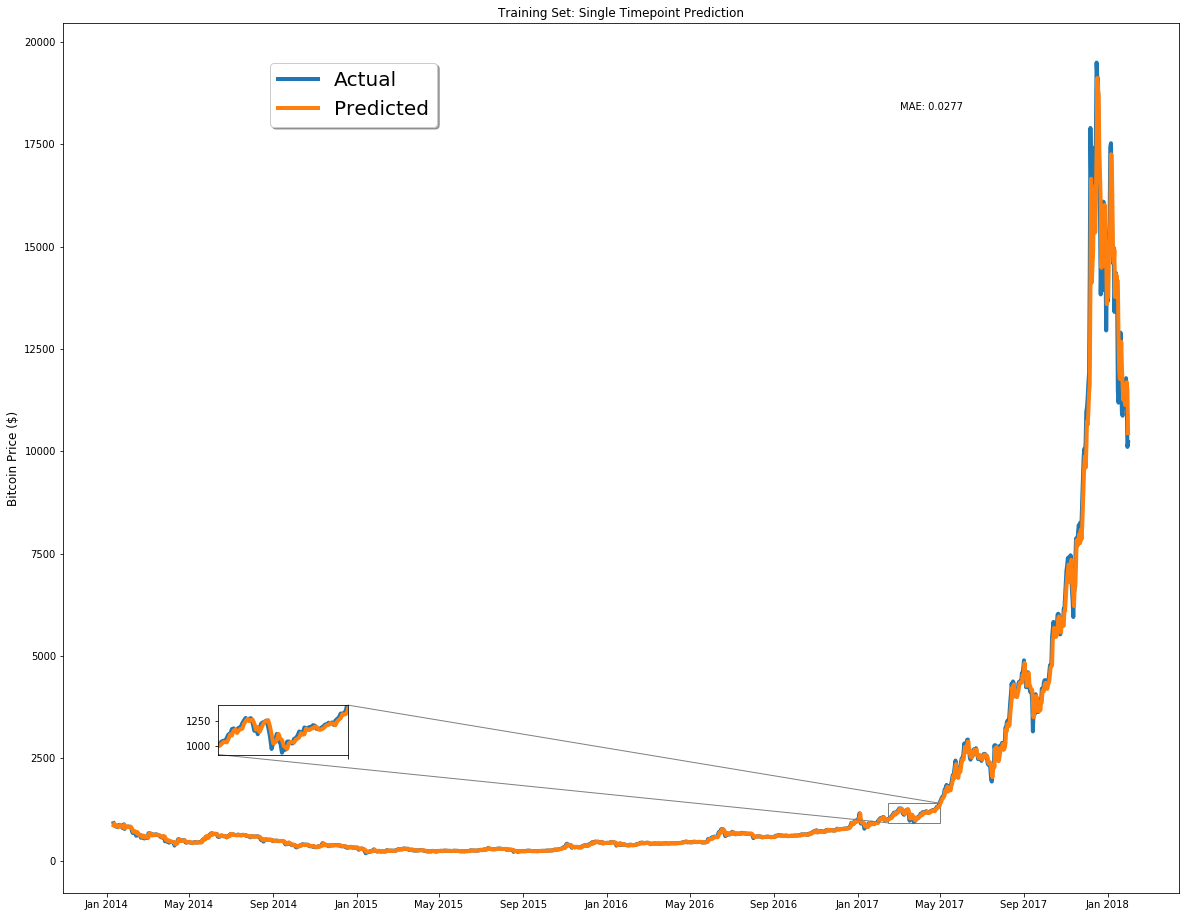

In [100]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2014,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2014,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

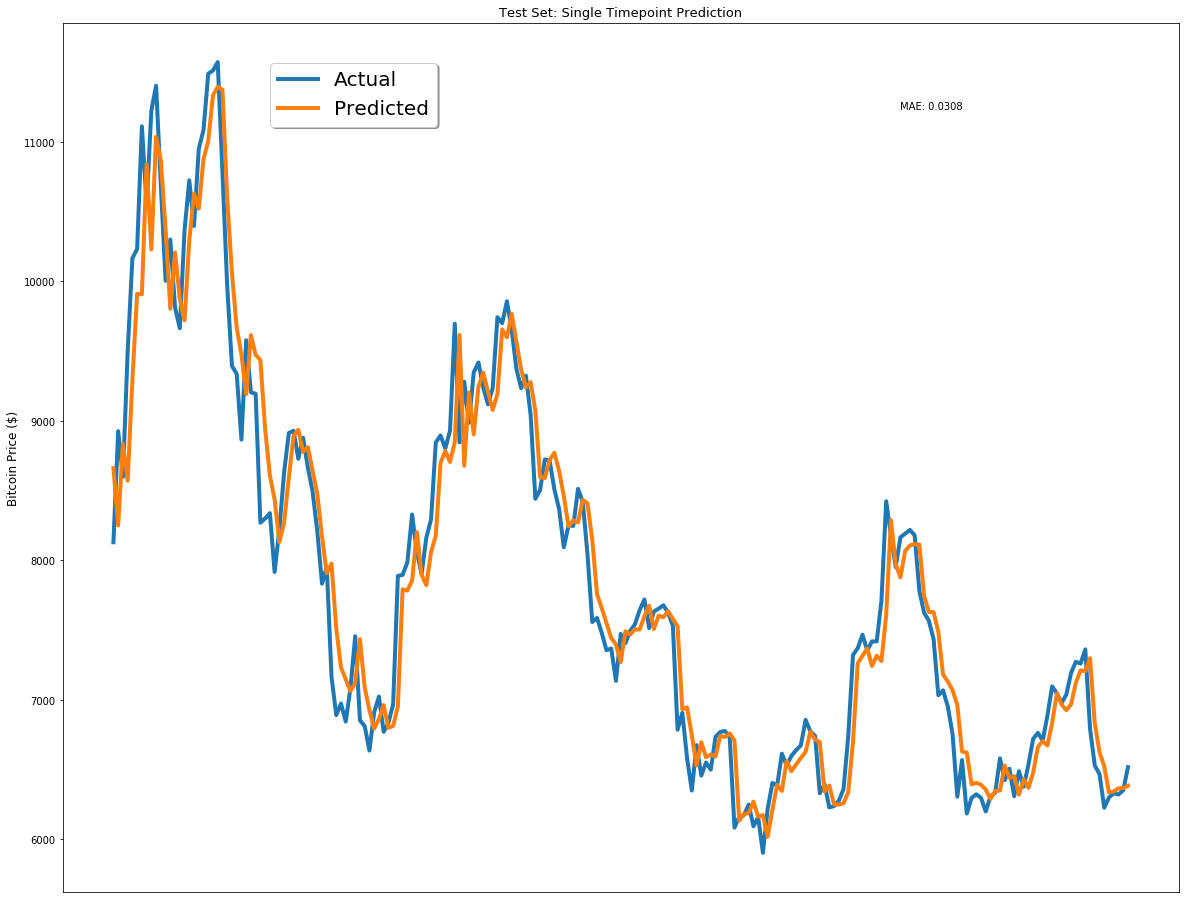

In [101]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()

In [125]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 30
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 7 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 39s - loss: 0.1811
Epoch 2/50
 - 32s - loss: 0.1525
Epoch 3/50
 - 27s - loss: 0.1483
Epoch 4/50
 - 32s - loss: 0.1448
Epoch 5/50
 - 30s - loss: 0.1445
Epoch 6/50
 - 29s - loss: 0.1433
Epoch 7/50
 - 28s - loss: 0.1410
Epoch 8/50
 - 28s - loss: 0.1413
Epoch 9/50
 - 33s - loss: 0.1407
Epoch 10/50
 - 24s - loss: 0.1388
Epoch 11/50
 - 26s - loss: 0.1394
Epoch 12/50
 - 26s - loss: 0.1388
Epoch 13/50
 - 26s - loss: 0.1395
Epoch 14/50
 - 26s - loss: 0.1397
Epoch 15/50
 - 28s - loss: 0.1398
Epoch 16/50
 - 34s - loss: 0.1376
Epoch 17/50
 - 29s - loss: 0.1383
Epoch 18/50
 - 31s - loss: 0.1365
Epoch 19/50
 - 30s - loss: 0.1374
Epoch 20/50
 - 31s - loss: 0.1370
Epoch 21/50
 - 29s - loss: 0.1365
Epoch 22/50
 - 34s - loss: 0.1355
Epoch 23/50
 - 32s - loss: 0.1360
Epoch 24/50
 - 33s - loss: 0.1351
Epoch 25/50
 - 30s - loss: 0.1344
Epoch 26/50
 - 29s - loss: 0.1316
Epoch 27/50
 - 27s - loss: 0.1344
Epoch 28/50
 - 29s - loss: 0.1335
Epoch 29/50
 - 27s - loss: 0.1319
Epoch 30/50
 - 28s - lo

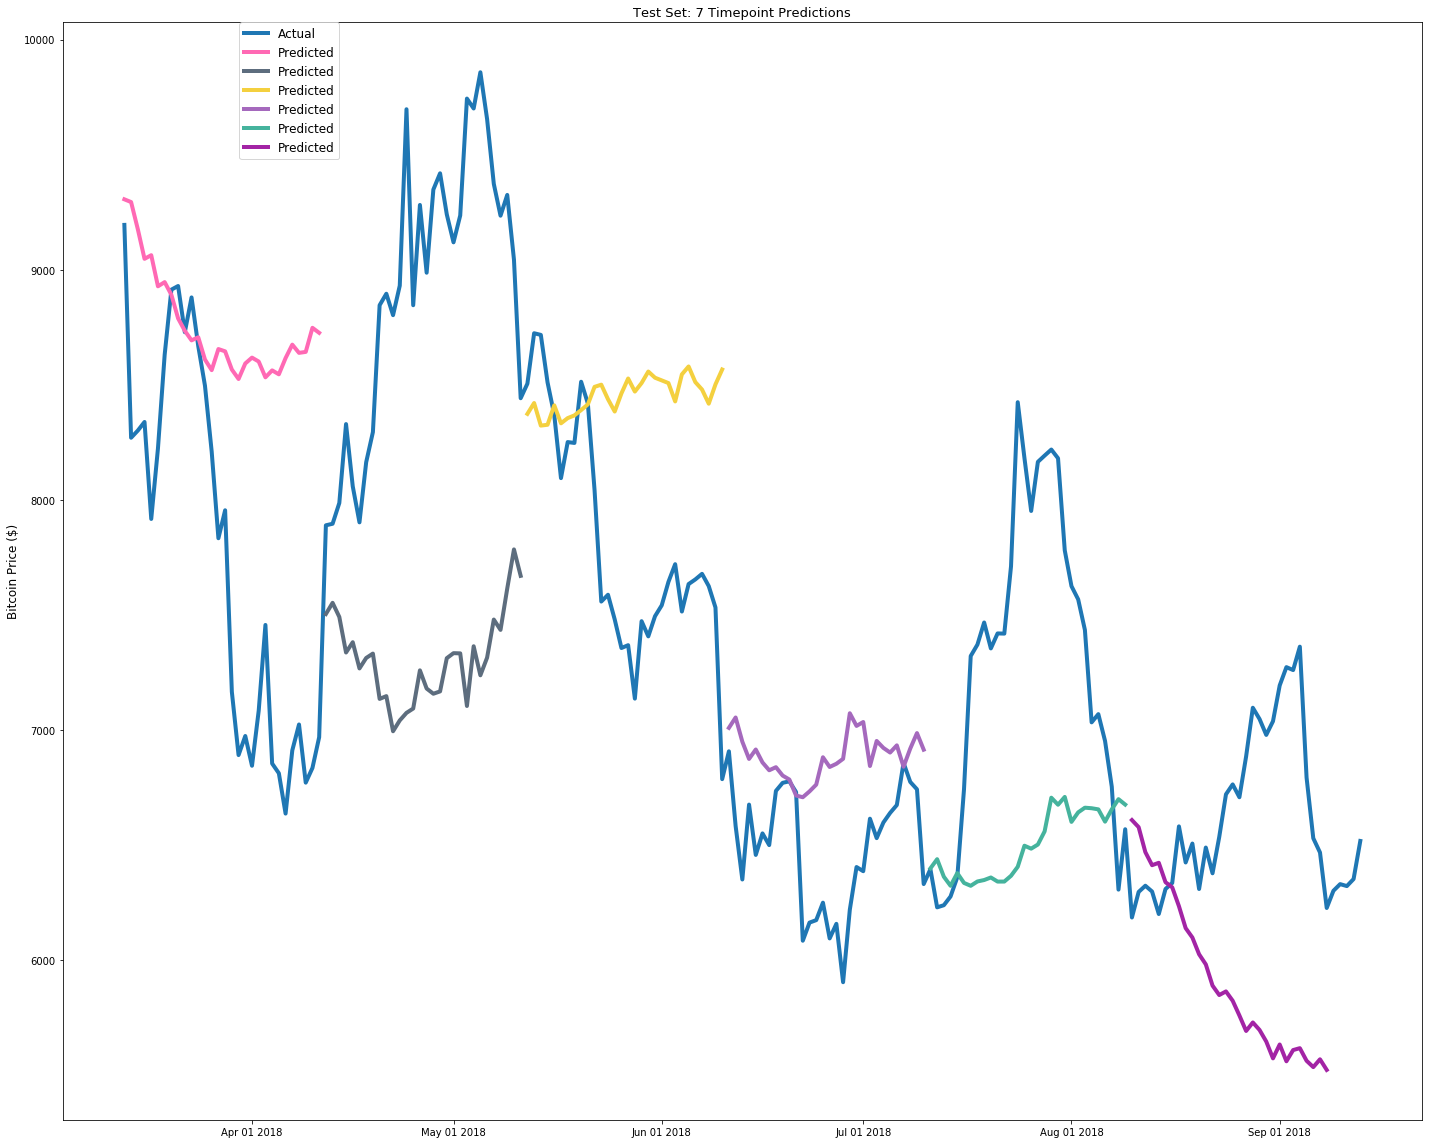

In [126]:
# little bit of reformatting the predictions to closing prices
# eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
#                    test_set['eth_Close'].values[:-(window_len + pred_range)][::7].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::30].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D", '#a324a5', '#59020c',
              "#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D", '#a324a5', '#59020c',
              "#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D", '#a324a5', '#59020c',
              "#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D", '#a324a5', '#59020c',
              "#FF69B4", "#5D6D7E"]
fig, (ax1) = plt.subplots(1,1)

fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
# ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
# ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
#          test_set['eth_Close'][window_len:], label='Actual')
for i, (bt_pred) in enumerate(bt_pred_prices):
    # Only adding lines to the legend once
    if i<30:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%30], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%7])
#     ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
#              eth_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 7 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
# ax1.set_xticklabels('')
# ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

The predictions are visibly less impressive than their single point counterparts. Nevertheless, I'm pleased that the model returned somewhat nuanced behaviours (e.g. the second line on the eth graph); it didn't simply forecast prices to move uniformly in one direction. So there are some grounds for optimism.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

## Summary

All in all, we collected some crypto data and fed it into LSTM deep layered network, you definitely don't have to be an expert to make use of keras, although I am suspicious whether you'd feel good without understanding any bit of it.
I do feel sceptic on LSTM though, and will try GRU and min GRU, also I will have to make a yearly prediction, which in my opinion is scary considering the volatility of the market.
I will always tweak the model by:

* **Changing Loss Functions**: MAE doesn't really encourage risk taking. For example, under mean squared error (MSE), the LSTM model would be forced to place more importance on detecting spikes/troughs. [More bespoke trading focused loss functions](http://www.faculty.ucr.edu/~taelee/paper/lossfunctions.pdf) could also move the model towards less conservative behaviours.

* **Get more and/or better data**: If past prices alone are sufficient to decently forecast future prices, we need to include other features that provide comparable predictive power. That way, the LSTM model wouldn't be so reliant on past prices, potentially unlocking more complex behaviours. This is probably the best and hardest solution.

I will also try to use [Facebook Prophet Algorithm](https://github.com/facebook/prophet), I feel really intrigued by it since it targets time-series only!